In [ ]:
!pip install optproblems

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 
  Created wheel for optproblems: filename=optproblems-1.3-py3-none-any.whl size=2040688 sha256=17c3d046c2f6152a93354236e2f07538e8788dbb79fd774a37a68d89c0ccafae
  Stored in directory: /root/.cache/pip/wheels/3a/8d/1b/762402c6cbdfd012cf3622d55b6460440d90dafe59dad0c013
Successfully built optproblems


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from optproblems import cec2005
from optproblems import Individual
from datetime import datetime
from statistics import mean 

In [ ]:
class Solution:
  def __init__(self,individual,score=0):
    self.individual = individual
    self.score = score
  def __str__(self) -> str:
     return 'SCORE ' + str(self.score) +' | INDIVIDUAL'+ str(self.individual)


In [ ]:
class Problem:
  def __init__(self,f):
    self.f = f
  
  def evaluate(self,sol):
      func =  self.f(len(sol))
      solution=Individual(sol)
      func.evaluate(solution)
      return solution.objective_values

  def optimal(self,length):
    func = self.f(length)
    solutions = func.get_optimal_solutions()
    for sol in solutions:
      func.evaluate(sol) # return single solution
      return sol.objective_values
    return 0

In [ ]:
class GA:

  @staticmethod
  def one_point_crossover(p1, p2): ## cross over parents
    a1 = p1.individual[:]
    b1 = p2.individual[:]
    pick = np.random.randint(0,len(p1.individual)) 
    crossed1 = np.concatenate((b1[:pick],a1[pick:]))
    crossed2 = np.concatenate((a1[:pick],b1[pick:]))
    return crossed1,crossed2

  @staticmethod
  def tournament_selection(population,k=3): ## tournament selection 
    selected = np.random.randint(len(population))
    for index in np.random.randint(0, len(population), k-1):
      if population[index].score < population[selected].score:
        selected = index
    return population[selected]


  @staticmethod
  def single_gene_random_mutation(vector_length,individual,bounds): ## single gene mutation, picking random gen and giving it a random value
    if(len(bounds) != 2):
      raise Exception('Input range should be an array/tuple of length 2')
    rand_pick_gene = np.random.randint(0,vector_length)
    individual.individual[rand_pick_gene] = np.random.uniform(bounds[0],bounds[1])

  

  @staticmethod
  def fitness(objFunc,solution,best_solution): ## simple fitness function, picking the best score (lower is better)
    solution.score=objFunc.evaluate(solution.individual) 
    if solution.score < best_solution.score:
        best_solution = solution
    return best_solution

  
  @staticmethod
  def termination(objFunc,solution):
    if((objFunc.optimal(len(solution.individual)) + 5) > solution.score): ## termination state when optimal solution is reached with an error of 5
      return True
    return False


  '''
  GA algorithm that initializes a population, iterating over them while doing a fitness assessment, selection and breeding.
  -	Selection -> Selection function [tournament selection is used following coursework specification]
  -	Mutation -> Mutation function [single gene random mutation is used following coursework specification]
  -	Crossover -> Cross over function [one point crossover is used following coursework specification]
  -	Fitness -> Fitness function a simple conditional picking the best score (using evaluate method from Problem class) 
  -	Termination -> Termination function [Compare optimal solution with the given solution (with a small error added)]
  -	Objective function -> a function from the test problems (f1,f2,f3…)
  -	n_gen -> number of generations
  -	pop_size -> Length of the population 
  -	Bounds -> bounds of the solution (Capped depending on the test functions spec)
  -	Vector size -> The vector size of the solution
  -	Elite rate -> How much to keep from the parents 

  Elitism is used to inject fit parents to next generation (Exploitative Variation)
  '''
  @staticmethod
  def Evolve(objFunc,fitness,selection,termination,crossover,mutation,n_gen,pop_size,bounds,vector_size=10,elite_rate=0.5):
    if(len(bounds) != 2):
      raise Exception('Input range of bounds should be an array/tuple of length 2')
    if(pop_size % 2 != 0):## keep population size divisible by 2
      pop_size+=1 
    population=  [Solution(individual) for individual in np.random.uniform(low=bounds[0],high=bounds[1],size=(np.abs(pop_size),np.abs(vector_size)))] ## initialize population
    np.random.shuffle(population)
    best_solution = population[np.random.randint(0,len(population))]
    history = []
    for gen in range(n_gen):
      for solution in population: 
        best_solution = fitness(objFunc,solution,best_solution)
        history.append(best_solution.score)
        if termination(objFunc,best_solution):
          print('Terminated -> reached termination state')
          return best_solution,history
      selected_parents = [selection(population) for _ in range(len(population))] ## Selection
      children = []
      for mate in range(0, len(population), 2):
        p1, p2 = selected_parents[mate], selected_parents[mate+1]
        reproduce = crossover(p1,p2) # cross over
        for gene in reproduce:
          child= Solution(gene)
          mutation(vector_size,child,bounds) ## mutation
          children.append(child)

      children.sort(key=lambda individual: individual.score, reverse=False) ## sort fittest children by score
      population.sort(key=lambda individual: individual.score, reverse=False) ## sort fittest parents by score
      elites_rate = int(len(population)* np.abs(elite_rate))  ## Elitism, keep percentage of top parents for next generation  
      population[-elites_rate:] = children[:elites_rate if elites_rate > 0 else len(children)]
    return best_solution,history

# Evaluation & Experiments

In [ ]:
f1 = Problem(cec2005.F1)
f2 = Problem(cec2005.F2)
f3 = Problem(cec2005.F3)
f4 = Problem(cec2005.F4)
f5 = Problem(cec2005.F5)
f6 = Problem(cec2005.F6)
f8 = Problem(cec2005.F8)

In [ ]:
def run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,runs=50):
  ## Evaluation 
  evaluation = {
      'accuracies': [],
      'timedRuns': [],
      'runs': [],
      'pop_length': POPULATION_LENGTH,
      'n_gen': GENERATION_ITER
  }
  for run in range(runs):
    print('RUN ',run+1)
    start_time = datetime.now()
    solution,data = GA.Evolve(objFunc=OBJECTIVE_FUNC,
                        fitness=GA.fitness,
                        selection=GA.tournament_selection,
                        crossover=GA.one_point_crossover,
                        mutation=GA.single_gene_random_mutation,
                        n_gen=GENERATION_ITER,
                        pop_size=POPULATION_LENGTH,
                        vector_size=VECTOR_LENGTH,
                        termination=GA.termination,
                        bounds=BOUNDS,
                        elite_rate=ELITE_RATE)
    delta_time = datetime.now() - start_time 
    timeTaken = delta_time.total_seconds() * 1000
    accuracy = (solution.score / OBJECTIVE_FUNC.optimal(VECTOR_LENGTH)) * 100

    evaluation['timedRuns'].append(timeTaken)
    evaluation['accuracies'].append(accuracy)
    evaluation['runs'].append(data)


    print('Time taken->',timeTaken, 'ms')
    print('Fittest individual->',solution)
    print('Accuracy ->',accuracy,'%')
    print('#####################################')
  return evaluation


In [ ]:
## Experiments parameetrs 
experiment_runs = 25

## Experiment 1

### F1

In [ ]:
## Running Experiment F1
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 1000
POPULATION_LENGTH = 10
BOUNDS = [-100,100]
ELITE_RATE = 0.5
OBJECTIVE_FUNC=f1
exp_f1 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)

RUN  1
Terminated -> reached termination state
Time taken-> 1664.45 ms
Fittest individual-> SCORE -445.55343119463316 | INDIVIDUAL[-39.61716627  58.34842098 -47.50267532 -74.31851646 -17.65774653
 -80.53382952 -10.07007929  24.39401809  88.98670399   9.80367694]
Accuracy -> 99.01187359880737 %
#####################################
RUN  2
Terminated -> reached termination state
Time taken-> 832.898 ms
Fittest individual-> SCORE -445.03145913074115 | INDIVIDUAL[-40.39987755  59.43606594 -47.44404656 -74.36123453 -15.88018211
 -79.69441414 -10.49271473  25.28816296  90.52780844   9.08962718]
Accuracy -> 98.89587980683136 %
#####################################
RUN  3
Terminated -> reached termination state
Time taken-> 569.431 ms
Fittest individual-> SCORE -445.26800279049957 | INDIVIDUAL[-38.87635779  59.70895393 -45.2831921  -73.58617172 -16.30746282
 -81.08960889 -10.38434865  25.43535936  89.4755334    8.25141028]
Accuracy -> 98.94844506455546 %
#####################################
R

### F4

In [ ]:
## Running Experiment F4
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 1500
POPULATION_LENGTH = 100
BOUNDS = [-100,100]
ELITE_RATE = 0.5
OBJECTIVE_FUNC=f4
exp_f4 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)

RUN  1
Terminated -> reached termination state
Time taken-> 9147.548999999999 ms
Fittest individual-> SCORE -445.0198869383215 | INDIVIDUAL[ 34.90526077 -80.94194727 -12.6725404  -82.62994642  84.36581986
  45.67114587 -89.32116465 -27.5925573   75.78325796 -39.03854675]
Accuracy -> 98.89330820851589 %
#####################################
RUN  2
Time taken-> 17743.718 ms
Fittest individual-> SCORE -417.72504250240434 | INDIVIDUAL[ 32.79572365 -76.70818703 -15.91747177 -79.88763009  80.18510365
  47.79468949 -89.43158045 -27.40443805  76.10725074 -37.4403713 ]
Accuracy -> 92.82778722275651 %
#####################################
RUN  3
Time taken-> 12070.867 ms
Fittest individual-> SCORE -439.0952611440473 | INDIVIDUAL[ 34.36003583 -80.31925244 -13.14422938 -80.39096716  80.9873568
  48.23165649 -90.75866345 -27.83402635  76.93938025 -39.28717382]
Accuracy -> 97.57672469867717 %
#####################################
RUN  4
Terminated -> reached termination state
Time taken-> 11297.008 

### F8

In [ ]:
## Running Experiment F8
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 100
POPULATION_LENGTH = 6
BOUNDS = [-32,32]
ELITE_RATE = 0.5
OBJECTIVE_FUNC = f8
exp_f8 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)


RUN  1
Time taken-> 80.664 ms
Fittest individual-> SCORE -119.07618904632132 | INDIVIDUAL[-14.70805877 -11.59638761   5.65969945   4.98974501 -23.27291015
  10.14359681  27.13977182  10.21391442   1.59741365 -27.76494251]
Accuracy -> 85.05442074737238 %
#####################################
RUN  2
Time taken-> 83.432 ms
Fittest individual-> SCORE -118.98315460080254 | INDIVIDUAL[ 31.95076881 -15.89477172  -1.13719126 -25.39685819  -1.52248436
  15.27418007  24.07573753  31.88168458 -19.94935505 -17.92267329]
Accuracy -> 84.9879675720018 %
#####################################
RUN  3
Time taken-> 89.408 ms
Fittest individual-> SCORE -119.17888136057596 | INDIVIDUAL[ -2.51437673 -30.88947613  -9.85710427 -31.28522891  28.95017467
  14.75382308  31.71675535   9.51252311  -8.64685123  22.3118035 ]
Accuracy -> 85.12777240041139 %
#####################################
RUN  4
Time taken-> 77.526 ms
Fittest individual-> SCORE -119.14729374256946 | INDIVIDUAL[  1.36972809  17.50510941 -12.97683

## Analysis

### F1, F4 ,F8

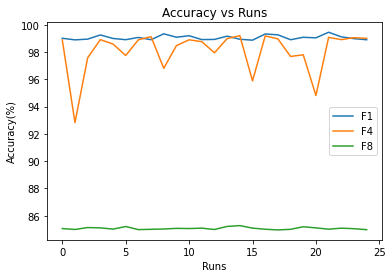

In [ ]:
x_axis = [i for i in range(experiment_runs)]
plt.plot(x_axis, exp_f1['accuracies'])
plt.plot(x_axis, exp_f4['accuracies'])
plt.plot(x_axis, exp_f8['accuracies'])

plt.title('Accuracy vs Runs')
plt.xlabel('Runs')
plt.ylabel('Accuracy(%)')
plt.legend(['F1', 'F4','F8'])
plt.show()

### F1

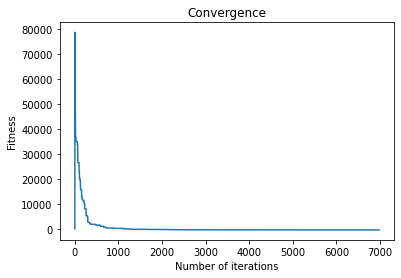

In [ ]:
## F1 Convergence Single Run
x_axis = [i for i in range(len(exp_f1['runs'][0]))]
plt.plot(x_axis, exp_f1['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F4

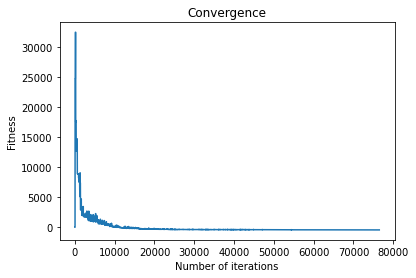

In [ ]:
## F4 Convergence Single Run
x_axis = [i for i in range(len(exp_f4['runs'][0]))]
plt.plot(x_axis, exp_f4['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F8

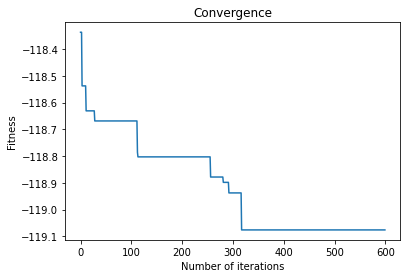

In [ ]:
## F8 Convergence Single Run
x_axis = [i for i in range(len(exp_f8['runs'][0]))]
plt.plot(x_axis, exp_f8['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

In [ ]:
best_exp_f1 = np.max(exp_f1['accuracies'])
print('Best F1 Accuracy->',best_exp_f1)
best_exp_f4 = np.max(exp_f4['accuracies'])
print('Best F4 Accuracy->',best_exp_f4)
best_exp_f8 = np.max(exp_f8['accuracies'])
print('Best F8 Accuracy->',best_exp_f8)

Best F1 Accuracy-> 99.454110789436
Best F4 Accuracy-> 99.20313852972869
Best F8 Accuracy-> 85.26998081555608


In [ ]:
worst_exp_f1 = np.min(exp_f1['accuracies'])
print('Worst F1 Accuracy->',worst_exp_f1)
worst_exp_f4 = np.min(exp_f4['accuracies'])
print('Worst F4 Accuracy->',worst_exp_f4)
worst_exp_f8 = np.min(exp_f8['accuracies'])
print('Worst F8 Accuracy->',worst_exp_f8)

Worst F1 Accuracy-> 98.87307643096736
Worst F4 Accuracy-> 92.82778722275651
Worst F8 Accuracy-> 84.95490729083059


In [ ]:
median_exp_f1 = np.median(exp_f1['accuracies'])
print('median F1 Accuracy->',median_exp_f1)
median_exp_f4 = np.median(exp_f4['accuracies'])
print('median F4 Accuracy->',median_exp_f4)
median_exp_f8 = np.median(exp_f8['accuracies'])
print('median F8 Accuracy->',median_exp_f8)

median F1 Accuracy-> 99.01187359880737
median F4 Accuracy-> 98.89330820851589
median F8 Accuracy-> 85.05442074737238


In [ ]:
reliability_exp_f1 = mean(exp_f1['accuracies'])
accuracy_exp_f1 = mean(exp_f1['accuracies'][0:20])
efficiency_exp_f1 = mean(exp_f1['timedRuns'])

print("Reliability",reliability_exp_f1)
print("Accuracy",accuracy_exp_f1)
print("Efficiency",efficiency_exp_f1)

Reliability 99.06114338328211
Accuracy 99.05121919079588
Efficiency 970.32


In [ ]:
reliability_exp_f4 = mean(exp_f4['accuracies'])
accuracy_exp_f4 = mean(exp_f4['accuracies'][0:20])
efficiency_exp_f4 = mean(exp_f4['timedRuns'])

print("Reliability",reliability_exp_f4)
print("Accuracy",accuracy_exp_f4)
print("Efficiency",efficiency_exp_f4)

Reliability 98.081396239842
Accuracy 98.05871507889755
Efficiency 10457.63532


In [ ]:
reliability_exp_f8 = mean(exp_f8['accuracies'])
accuracy_exp_f8 = mean(exp_f8['accuracies'][0:20])
efficiency_exp_f8 = mean(exp_f8['timedRuns'])

print("Reliability",reliability_exp_f8)
print("Accuracy",accuracy_exp_f8)
print("Efficiency",efficiency_exp_f8)

Reliability 85.06462315775482
Accuracy 85.0700217424141
Efficiency 85.9144


## Experiment 2

### F1

In [ ]:
## Running Experiment F1
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 250
POPULATION_LENGTH = 10
BOUNDS = [-100,100]
ELITE_RATE = 0.5
OBJECTIVE_FUNC=f1
exp2_f1 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)

RUN  1
Time taken-> 233.89 ms
Fittest individual-> SCORE -405.4835652202593 | INDIVIDUAL[-38.16670298  55.5135617  -44.57319601 -73.5835817  -13.63744252
 -79.90329529 -11.50836376  21.91838559  88.39999124   6.89552459]
Accuracy -> 90.1074589378354 %
#####################################
RUN  2
Time taken-> 201.85 ms
Fittest individual-> SCORE -386.8700335399885 | INDIVIDUAL[-40.16260126  57.56653088 -45.82003302 -76.08847021 -22.36845901
 -81.49036708 -11.22379763  22.42227446  93.80679007  11.05391004]
Accuracy -> 85.9711185644419 %
#####################################
RUN  3
Time taken-> 220.611 ms
Fittest individual-> SCORE -429.03670189193986 | INDIVIDUAL[-36.63745638  57.09034883 -46.22120854 -76.03591007 -17.8674839
 -80.79847672  -9.84137882  22.49440039  89.35867133   8.41690062]
Accuracy -> 95.34148930931997 %
#####################################
RUN  4
Time taken-> 237.154 ms
Fittest individual-> SCORE -388.6469357466658 | INDIVIDUAL[-38.87726787  63.56089435 -42.857388  

### F4

In [ ]:
## Running Experiment F4
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 250
POPULATION_LENGTH = 10
BOUNDS = [-100,100]
ELITE_RATE = 0.5
OBJECTIVE_FUNC=f4
exp2_f4 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)

RUN  1
Time taken-> 233.67 ms
Fittest individual-> SCORE 1387.5736838748478 | INDIVIDUAL[ 22.17675001 -67.79363432 -21.45278462 -58.91894534  90.34396522
  14.63112425 -98.36246339   8.48155491  58.10587171 -38.01627406]
Accuracy -> -308.349707527744 %
#####################################
RUN  2
Time taken-> 232.12 ms
Fittest individual-> SCORE 669.2163621519869 | INDIVIDUAL[ 31.18835702 -63.50160086 -42.10069367 -72.30879481  88.53807168
  23.7214281  -67.42605391 -24.48704577  72.34149987 -37.73762149]
Accuracy -> -148.71474714488596 %
#####################################
RUN  3
Time taken-> 231.958 ms
Fittest individual-> SCORE 4584.084769663237 | INDIVIDUAL[  5.40530208 -31.51483725 -46.33330721 -35.45745048  73.63622437
  -9.79062104 -46.5652306  -34.03171096  69.26387955 -12.54142396]
Accuracy -> -1018.6855043696082 %
#####################################
RUN  4
Time taken-> 227.27100000000002 ms
Fittest individual-> SCORE 354.13871393673605 | INDIVIDUAL[ 23.96969843 -84.015667

### F8

In [ ]:
## Running Experiment F8
## Hyperparameters
VECTOR_LENGTH = 10
GENERATION_ITER = 250
POPULATION_LENGTH = 6
BOUNDS = [-32,32]
ELITE_RATE = 0.5
OBJECTIVE_FUNC = f8
exp2_f8 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,GENERATION_ITER,POPULATION_LENGTH,BOUNDS,ELITE_RATE,experiment_runs)


RUN  1
Time taken-> 205.231 ms
Fittest individual-> SCORE -119.22005508746334 | INDIVIDUAL[-18.80006786 -10.37383301  11.26126943 -13.26438095  -8.86382691
  28.99414501  -4.70937793   6.86611268  27.74225514  19.21561753]
Accuracy -> 85.15718220533095 %
#####################################
RUN  2
Time taken-> 223.748 ms
Fittest individual-> SCORE -119.2927092015405 | INDIVIDUAL[-24.51511502  29.71014612 -26.39079296 -17.54698255 -28.32855016
  -0.13290934   4.48639305   0.346715    28.14766484 -11.99107531]
Accuracy -> 85.20907800110035 %
#####################################
RUN  3
Time taken-> 198.063 ms
Fittest individual-> SCORE -119.18851802927355 | INDIVIDUAL[ 18.61853637 -24.16944752   4.06752859  15.41957886 -18.75292352
  11.1708501   25.54422372 -11.1693541  -12.80237918  15.50368398]
Accuracy -> 85.1346557351954 %
#####################################
RUN  4
Time taken-> 229.47400000000002 ms
Fittest individual-> SCORE -119.19712326168923 | INDIVIDUAL[  1.66363306  22.7473

## Analysis

### F1, F4 ,F8

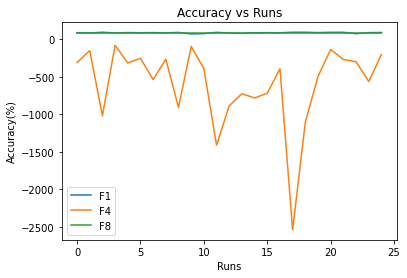

In [ ]:
x_axis = [i for i in range(experiment_runs)]
plt.plot(x_axis, exp2_f1['accuracies'])
plt.plot(x_axis, exp2_f4['accuracies'])
plt.plot(x_axis, exp2_f8['accuracies'])

plt.title('Accuracy vs Runs')
plt.xlabel('Runs')
plt.ylabel('Accuracy(%)')
plt.legend(['F1', 'F4','F8'])
plt.show()

### F1

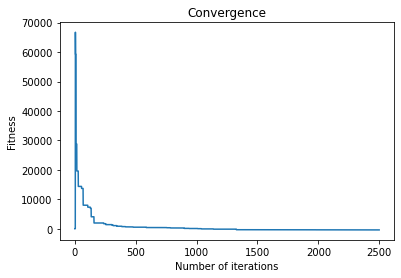

In [ ]:
## F1 Convergence Single Run
x_axis = [i for i in range(len(exp2_f1['runs'][0]))]
plt.plot(x_axis, exp2_f1['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F4

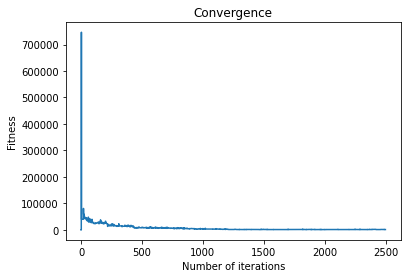

In [ ]:
## F4 Convergence Single Run
x_axis = [i for i in range(len(exp2_f4['runs'][0]))]
plt.plot(x_axis, exp2_f4['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F8

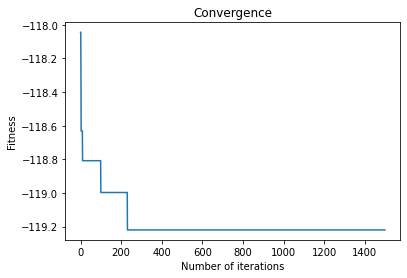

In [ ]:
## F8 Convergence Single Run
x_axis = [i for i in range(len(exp2_f8['runs'][0]))]
plt.plot(x_axis, exp2_f8['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

In [ ]:
best_exp2_f1 = np.max(exp2_f1['accuracies'])
print('Best F1 Accuracy->',best_exp2_f1)
best_exp2_f4 = np.max(exp2_f4['accuracies'])
print('Best F4 Accuracy->',best_exp2_f4)
best_exp2_f8 = np.max(exp2_f8['accuracies'])
print('Best F8 Accuracy->',best_exp2_f8)

Best F1 Accuracy-> 95.53361797615088
Best F4 Accuracy-> -78.69749198594135
Best F8 Accuracy-> 85.35643248800415


In [ ]:
worst_exp2_f1 = np.min(exp2_f1['accuracies'])
print('Worst F1 Accuracy->',worst_exp2_f1)
worst_exp2_f4 = np.min(exp2_f4['accuracies'])
print('Worst F4 Accuracy->',worst_exp2_f4)
worst_exp2_f8 = np.min(exp2_f8['accuracies'])
print('Worst F8 Accuracy->',worst_exp2_f8)

Worst F1 Accuracy-> 73.2390109135311
Worst F4 Accuracy-> -2539.310542351707
Worst F8 Accuracy-> 85.01288496722734


In [ ]:
median_exp2_f1 = np.median(exp2_f1['accuracies'])
print('median F1 Accuracy->',median_exp2_f1)
median_exp2_f4 = np.median(exp2_f4['accuracies'])
print('median F4 Accuracy->',median_exp2_f4)
median_exp2_f8 = np.median(exp2_f8['accuracies'])
print('median F8 Accuracy->',median_exp2_f8)

median F1 Accuracy-> 90.1074589378354
median F4 Accuracy-> -391.06549220512886
median F8 Accuracy-> 85.15765635577691


In [ ]:
reliability_exp2_f1 = mean(exp2_f1['accuracies'])
accuracy_exp2_f1 = mean(exp2_f1['accuracies'][0:20])
efficiency_exp2_f1 = mean(exp2_f1['timedRuns'])

print("Reliability",reliability_exp2_f1)
print("Accuracy",accuracy_exp2_f1)
print("Efficiency",efficiency_exp2_f1)

Reliability 88.69368060657602
Accuracy 88.48042900345388
Efficiency 211.812


In [ ]:
reliability_exp2_f4 = mean(exp2_f4['accuracies'])
accuracy_exp2_f4 = mean(exp2_f4['accuracies'][0:20])
efficiency_exp2_f4 = mean(exp2_f4['timedRuns'])

print("Reliability",reliability_exp2_f4)
print("Accuracy",accuracy_exp2_f4)
print("Efficiency",efficiency_exp2_f4)

Reliability -592.6949980519876
Accuracy -667.6438187380891
Efficiency 230.12292


In [ ]:
reliability_exp2_f8 = mean(exp2_f8['accuracies'])
accuracy_exp2_f8 = mean(exp2_f8['accuracies'][0:20])
efficiency_exp2_f8 = mean(exp2_f8['timedRuns'])

print("Reliability",reliability_exp2_f8)
print("Accuracy",accuracy_exp2_f8)
print("Efficiency",efficiency_exp2_f8)

Reliability 85.17379762959825
Accuracy 85.17450577977901
Efficiency 210.36468
